In [129]:
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Name: Jonah Zembower
# Date: March 11, 2025
# Project: EY Data Science Challenge 2025
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# Introduction:

The model was not accurate for the neural network to what we had hoped. There were better results seen in the random forest method while developing feature importance. That is what we go in depth here. 

# Libraries and Data:

Importing necessary libraries:

In [2]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For the geodataframe
import geopandas as gpd
from shapely import wkt
from scipy.spatial import cKDTree

# Random forest libraries:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.spatial import cKDTree
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

Importing datasets:

In [3]:
# Satellite Data:
all_bands_granular = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_granular.csv")
all_bands_noisy_proximity = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_noisy_proximity.csv")
all_bands_proximity_rounded_3 = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_proximity_rounded_3.csv")
all_bands_proximity_rounded_3_mapped = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_proximity_rounded_3_mapped.csv")
indices_granular = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\indices_granular.csv")
landsat_thermal_granular = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\landsat_thermal_granular.csv")
noisy_long_lat_uhi = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\noisy_long_lat_uhi.csv")
noisy_5_bands_proxmity = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\5_noisy_all_bands_proximity.csv")

In [4]:
# Elevation Data:
all_elevation_nyc = pd.read_csv("C:\\Users\\jrzem\OneDrive\\Desktop\\EY Dataset\\Elevation\\all_elevation_nyc.csv")

In [5]:
# Load the test data
test_data = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Submission_template.csv")

In [6]:
test_data

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN
...,...,...,...
1035,-73.919388,40.813803,NaN
1036,-73.931033,40.833178,NaN
1037,-73.934647,40.854542,NaN
1038,-73.917223,40.815413,NaN


# Random Forest Models:

1. sentinel (BO1, BO6 proximity) and elevation (building height only and natural elevation proximity)

### Model 1:

In [134]:
# Add the landsat_thermal_granular data to the all_bands_proximity_rounded_3_mapped data
all_bands_elevation_2 = all_bands_proximity_rounded_3_mapped.merge(all_elevation_nyc[['Longitude', 'Latitude', 'Building Height Only Proximity','Natural Proximity']], on=['Longitude', 'Latitude'])
all_bands_elevation_2

# Save to CSV
all_bands_elevation_2.to_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_elevation_2.csv", index=False)

# Load dataset
all_bands_elevation_2 = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_elevation_2.csv")

In [135]:
# Load dataset
df = all_bands_elevation_2.copy()

# Define spectral features
spectral_features = ['BO1', 'BO6', 'Building Height Only Proximity','Natural Proximity']

# Select features and target
X = df[spectral_features]
y = df['UHI Index']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Not necessary for Random Forest but kept for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [136]:
# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluate model performance
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")


Model Performance:
 - MAE: 0.0033
 - RMSE: 0.0047


In [137]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist,
    n_iter=10, cv=3, scoring='neg_mean_absolute_error',
    verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

# Get the best model from hyperparameter tuning
best_rf_model = random_search.best_estimator_

# Enable Out-of-Bag (OOB) Score for validation
best_rf_model.set_params(oob_score=True)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate model on the test set
y_pred = best_rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation results
print(f"Optimized Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")
print(f"OOB Score: {best_rf_model.oob_score_}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimized Model Performance:
 - MAE: 0.0033
 - RMSE: 0.0047
OOB Score: 0.9183127402317672


The Hyperparameter tuning showcases the model is already performing well, and there is no need to update it. 

In [138]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds nearest spectral data to submission dataset using KDTree.

    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing submission locations (Latitude, Longitude).
        data_to_map (pd.DataFrame): DataFrame containing spectral band values.

    Returns:
        pd.DataFrame: Submission dataset with matched spectral data.
    """
    # Extract coordinates
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree
    tree = cKDTree(elevation_coords)
    
    # Find nearest neighbors
    _, indices = tree.query(uhi_coords)
    
    # Add matched spectral data
    uhi_data = uhi_data.copy()
    for col in spectral_features:
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

# Match spectral features for submission data
submission_all_bands_elevation = add_nearest_data(test_data, all_bands_elevation_2)


In [139]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions_1 = rf_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions_1

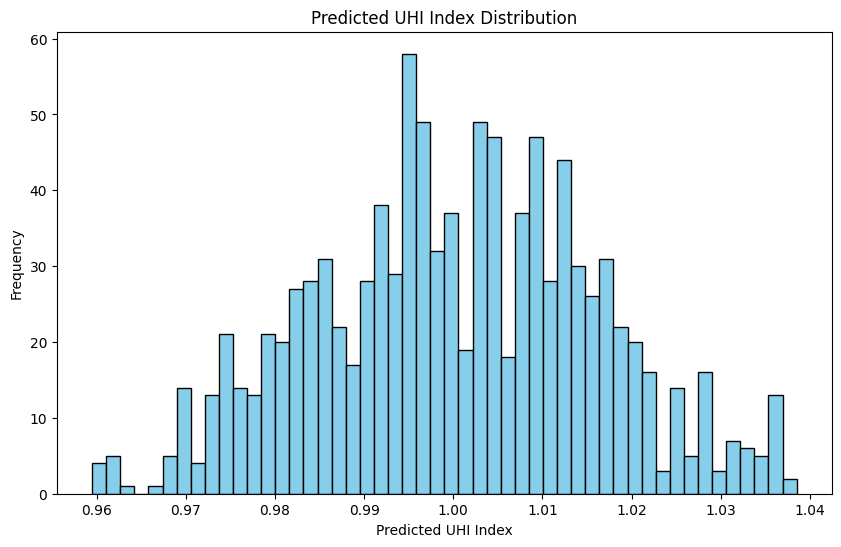

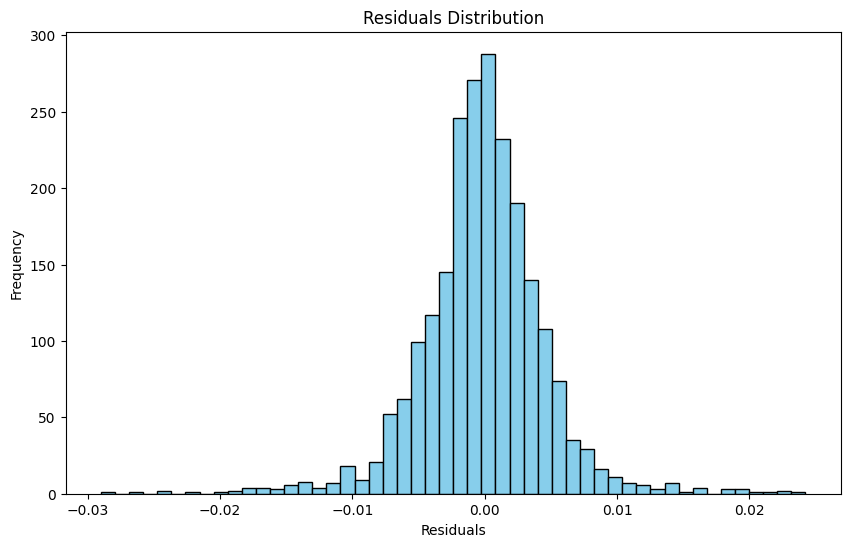

In [140]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.hist(submission_predictions_1, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Predicted UHI Index')
plt.ylabel('Frequency')
plt.title('Predicted UHI Index Distribution')
plt.show()

# Plot Residuals
plt.figure(figsize=(10, 6))
plt.hist(y_test - y_pred, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()


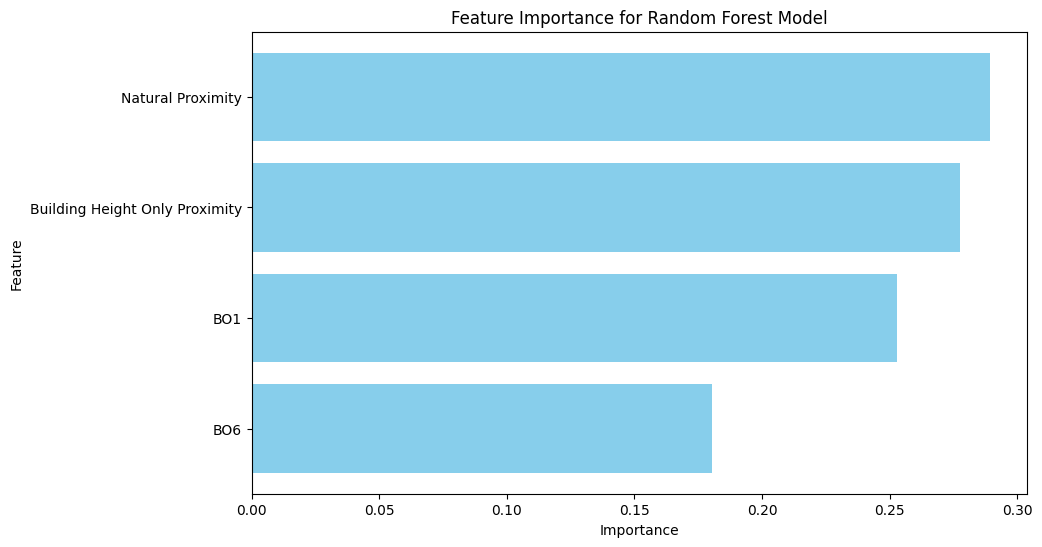

In [141]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [142]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

This model was 0.9243. This will be one of our best scores and best predicting models. We will look at some other factors as well soon.

### Model 2:

In [143]:
# Implementing Feature Engineering: Normalizing by Maximum Values with Random Forest
# Normalize data by maximum values (excluding the target variable 'UHI Index')
X_train_normalized = X_train / X_train.max()
X_test_normalized = X_test / X_train.max()  # Use training max to prevent data leakage

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=300, max_depth=20, 
                                 min_samples_split=5, min_samples_leaf=2, 
                                 bootstrap=True, max_samples=0.8, 
                                 oob_score=True, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train_normalized, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_normalized)

# Evaluate model performance
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Print performance metrics
print(f"Random Forest Model with Max Normalization:\n - MAE: {mae_rf:.4f}\n - RMSE: {rmse_rf:.4f}")
print(f"OOB Score: {rf_model.oob_score_}")


Random Forest Model with Max Normalization:
 - MAE: 0.0035
 - RMSE: 0.0049
OOB Score: 0.9082305103308425


In [144]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions = rf_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions

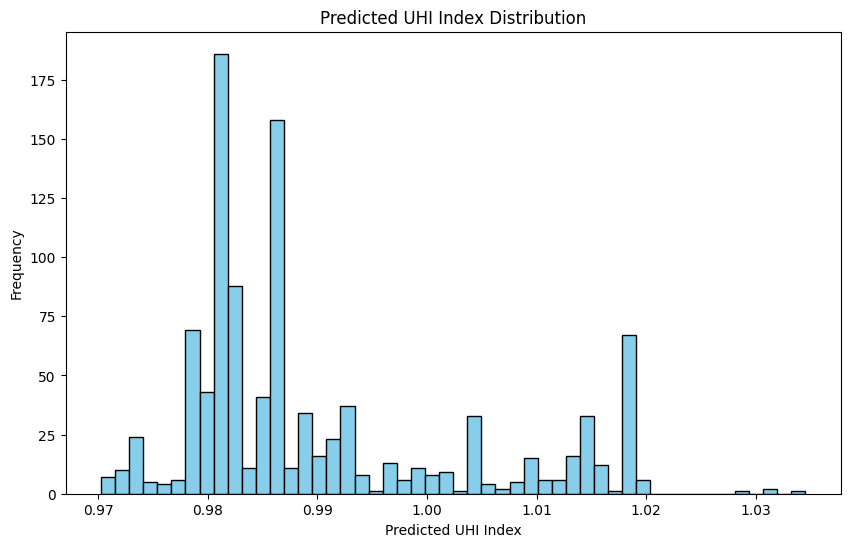

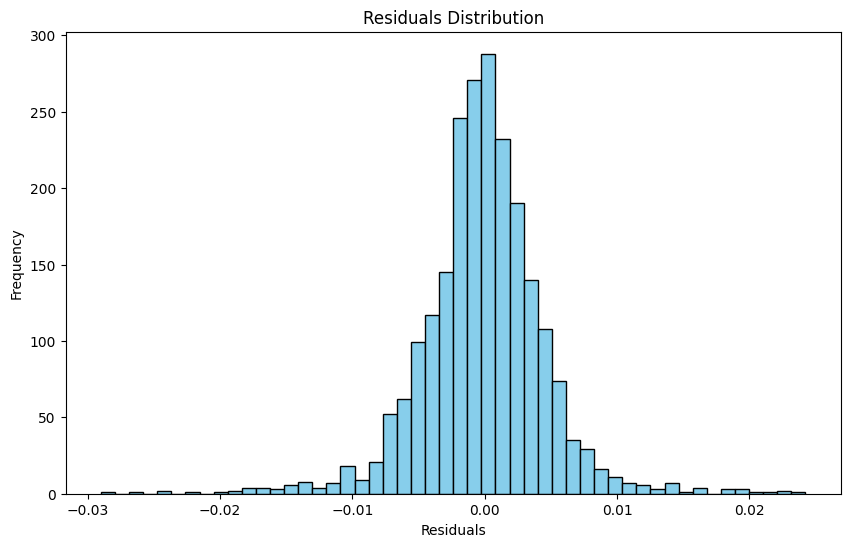

In [145]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.hist(submission_predictions, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Predicted UHI Index')
plt.ylabel('Frequency')
plt.title('Predicted UHI Index Distribution')
plt.show()

# Plot Residuals
plt.figure(figsize=(10, 6))
plt.hist(y_test - y_pred, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

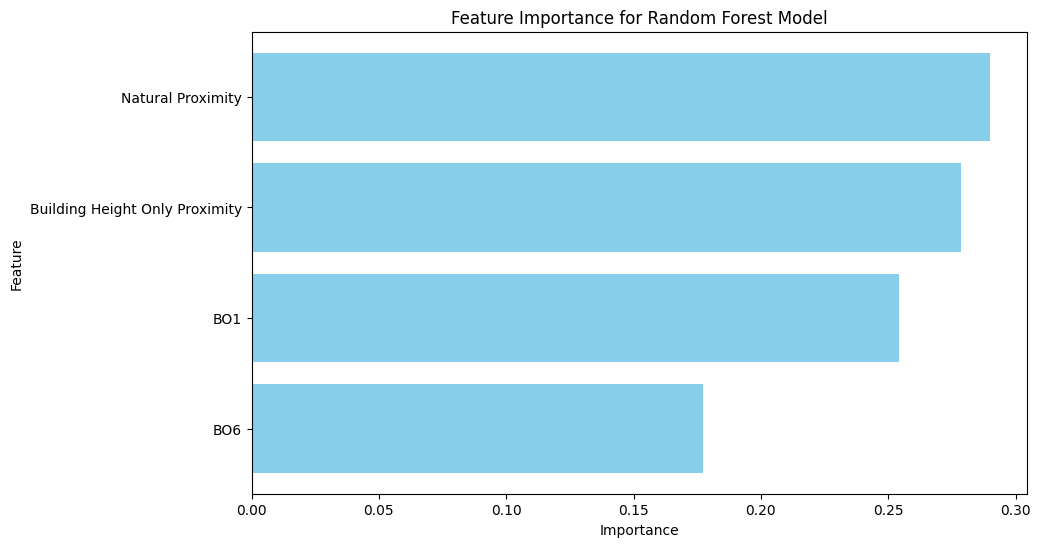

In [146]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [147]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

This didn't perform as well as we would hope. The standard scaling method is most appropriate.

### Model 3:

- Look at the all bands with noisy data. This is the noisy data with rounded to 3 median. 
- We are still assessing the BO1 and BO6 with the Building Elevation and Natural Elevation.

In [148]:
# Add the landsat_thermal_granular data to the all_bands_proximity_rounded_3_mapped data
all_bands_elevation_5_noisy = noisy_5_bands_proxmity.merge(all_elevation_nyc[['Longitude', 'Latitude', 'Building Height Only Proximity','Natural Proximity']], on=['Longitude', 'Latitude'])
all_bands_elevation_5_noisy

# Save to CSV
all_bands_elevation_5_noisy.to_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_elevation_5_noisy.csv", index=False)

# Load dataset
all_bands_elevation_5_noisy = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_elevation_5_noisy.csv")

In [149]:
# Load dataset
df = all_bands_elevation_5_noisy.copy()

# Define spectral features
spectral_features = ['BO1', 'BO6', 'Building Height Only Proximity','Natural Proximity']

# Select features and target
X = df[spectral_features]
y = df['UHI Index']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Not necessary for Random Forest but kept for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [150]:
# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluate model performance
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")

Model Performance:
 - MAE: 0.0033
 - RMSE: 0.0048


In [151]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist,
    n_iter=10, cv=3, scoring='neg_mean_absolute_error',
    verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

# Get the best model from hyperparameter tuning
best_rf_model = random_search.best_estimator_

# Enable Out-of-Bag (OOB) Score for validation
best_rf_model.set_params(oob_score=True)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate model on the test set
y_pred = best_rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation results
print(f"Optimized Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")
print(f"OOB Score: {best_rf_model.oob_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimized Model Performance:
 - MAE: 0.0033
 - RMSE: 0.0048
OOB Score: 0.9194909114051754


In [152]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds nearest spectral data to submission dataset using KDTree.

    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing submission locations (Latitude, Longitude).
        data_to_map (pd.DataFrame): DataFrame containing spectral band values.

    Returns:
        pd.DataFrame: Submission dataset with matched spectral data.
    """
    # Extract coordinates
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree
    tree = cKDTree(elevation_coords)
    
    # Find nearest neighbors
    _, indices = tree.query(uhi_coords)
    
    # Add matched spectral data
    uhi_data = uhi_data.copy()
    for col in spectral_features:
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

# Match spectral features for submission data
submission_all_bands_elevation = add_nearest_data(test_data, all_bands_elevation_5_noisy)


In [153]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions_3 = rf_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions_3

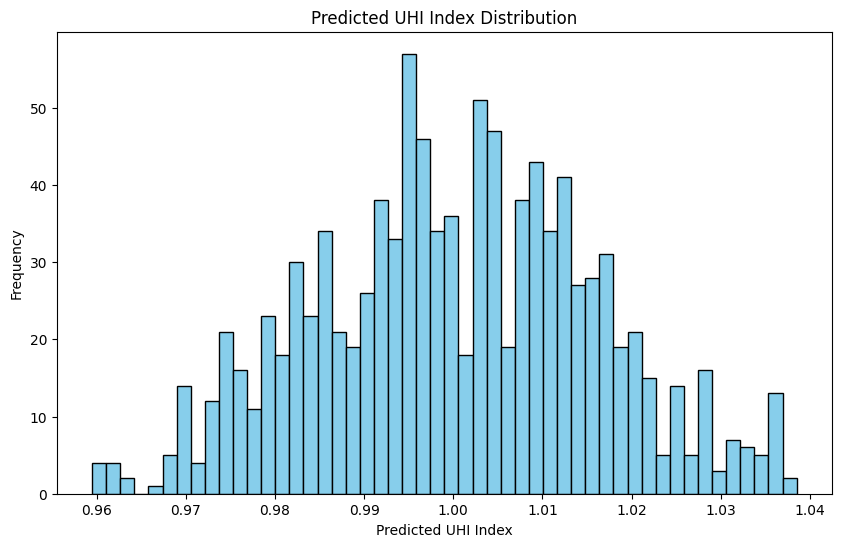

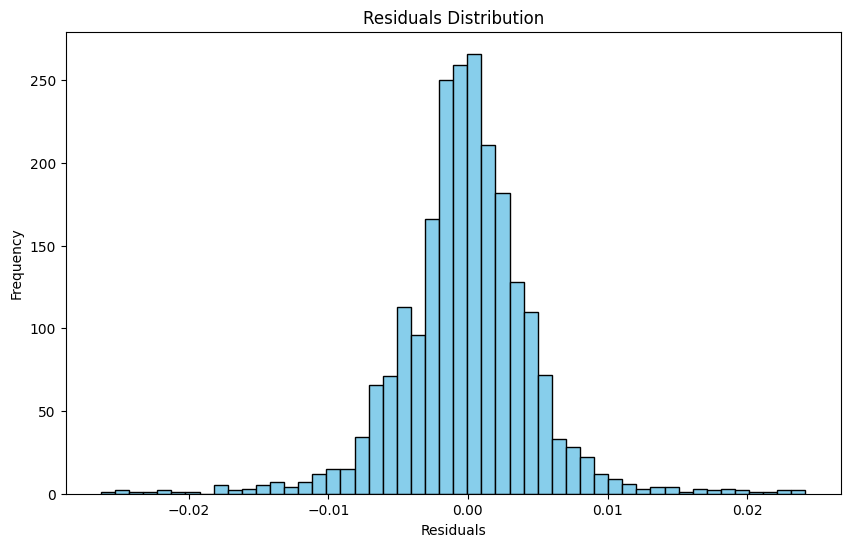

In [154]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.hist(submission_predictions_3, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Predicted UHI Index')
plt.ylabel('Frequency')
plt.title('Predicted UHI Index Distribution')
plt.show()

# Plot Residuals
plt.figure(figsize=(10, 6))
plt.hist(y_test - y_pred, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

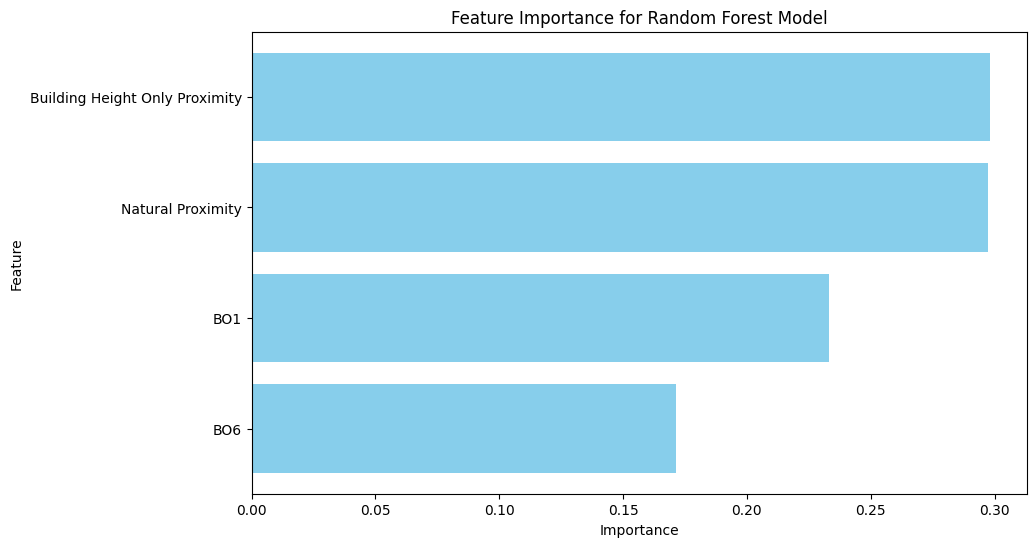

In [155]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [156]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

This got a 0.9255, which this was our best score for the random forest model.

# Comparing Models:

### Model 1 vs. Model 3:

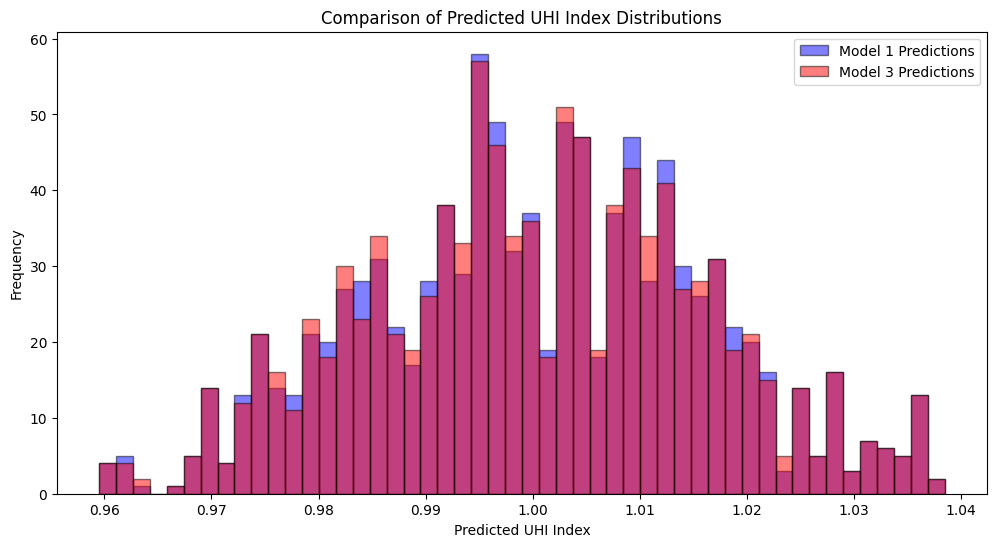

In [157]:
# Plot histograms for comparison
plt.figure(figsize=(12, 6))

# Histogram for submission_predictions_1
plt.hist(submission_predictions_1, bins=50, alpha=0.5, label='Model 1 Predictions', color='blue', edgecolor='black')

# Histogram for submission_predictions_3
plt.hist(submission_predictions_3, bins=50, alpha=0.5, label='Model 3 Predictions', color='red', edgecolor='black')

# Add labels and title
plt.xlabel('Predicted UHI Index')
plt.ylabel('Frequency')
plt.title('Comparison of Predicted UHI Index Distributions')
plt.legend()

# Show plot
plt.show()

### Predicting Lower UHI by Scaling:

In [158]:
noisy_5_bands_proxmity = pd.read_csv("C:\\Users\\jrzem\\Downloads\\5_noisy_all_bands_proximity.csv")

In [159]:
noisy_5_bands_proxmity

,Unnamed: 0,Longitude,Latitude,datetime,UHI Index,BO1,BO2,BO3,BO4,BO5,BO6,BO7,BO8,B8A,B11,B12
0,0,-73.909167,40.813107,24-07-2021 15:53,1.030289,841.5,795.5,920.5,936.0,1212.0,1783.0,2042.0,2075.0,2186.0,1617.5,1305.5
1,1,-73.909187,40.813045,24-07-2021 15:53,1.030289,841.5,795.5,920.5,936.0,1212.0,1783.0,2042.0,2075.0,2186.0,1617.5,1305.5
2,2,-73.909215,40.812978,24-07-2021 15:53,1.023798,841.5,795.5,920.5,936.0,1212.0,1783.0,2042.0,2075.0,2186.0,1617.5,1305.5
3,3,-73.909242,40.812908,24-07-2021 15:53,1.023798,841.5,795.5,920.5,936.0,1212.0,1783.0,2042.0,2075.0,2186.0,1617.5,1305.5
4,4,-73.909257,40.812845,24-07-2021 15:53,1.021634,841.5,795.5,920.5,936.0,1212.0,1783.0,2042.0,2075.0,2186.0,1617.5,1305.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,11224,-73.957050,40.790333,24-07-2021 15:57,0.972470,462.5,506.5,725.5,501.0,999.0,2612.0,3111.5,3179.5,3446.5,1925.0,1072.5
11225,11225,-73.957063,40.790308,24-07-2021 15:57,0.972470,462.5,506.5,725.5,501.0,999.0,2612.0,3111.5,3179.5,3446.5,1925.0,1072.5
11226,11226,-73.957093,40.790270,24-07-2021 15:57,0.981124,462.5,506.5,725.5,501.0,999.0,2612.0,3111.5,3179.5,3446.5,1925.0,1072.5
11227,11227,-73.957112,40.790253,24-07-2021 15:59,0.981245,462.5,506.5,725.5,501.0,999.0,2612.0,3111.5,3179.5,3446.5,1925.0,1072.5


In [160]:
# Scale down the UHI index values by a factor (e.g., 0.9)
scaling_factor = 0.99
noisy_5_bands_proxmity['UHI Index'] *= scaling_factor

# Save the modified dataset to a new CSV file
noisy_5_bands_proxmity.to_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\noisy_5_bands_proximity_scaled.csv", index=False)

# Load the modified dataset
noisy_5_bands_proxmity_scaled = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\noisy_5_bands_proximity_scaled.csv")

noisy_5_bands_proxmity_scaled

,Unnamed: 0,Longitude,Latitude,datetime,UHI Index,BO1,BO2,BO3,BO4,BO5,BO6,BO7,BO8,B8A,B11,B12
0,0,-73.909167,40.813107,24-07-2021 15:53,1.019986,841.5,795.5,920.5,936.0,1212.0,1783.0,2042.0,2075.0,2186.0,1617.5,1305.5
1,1,-73.909187,40.813045,24-07-2021 15:53,1.019986,841.5,795.5,920.5,936.0,1212.0,1783.0,2042.0,2075.0,2186.0,1617.5,1305.5
2,2,-73.909215,40.812978,24-07-2021 15:53,1.013560,841.5,795.5,920.5,936.0,1212.0,1783.0,2042.0,2075.0,2186.0,1617.5,1305.5
3,3,-73.909242,40.812908,24-07-2021 15:53,1.013560,841.5,795.5,920.5,936.0,1212.0,1783.0,2042.0,2075.0,2186.0,1617.5,1305.5
4,4,-73.909257,40.812845,24-07-2021 15:53,1.011418,841.5,795.5,920.5,936.0,1212.0,1783.0,2042.0,2075.0,2186.0,1617.5,1305.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,11224,-73.957050,40.790333,24-07-2021 15:57,0.962745,462.5,506.5,725.5,501.0,999.0,2612.0,3111.5,3179.5,3446.5,1925.0,1072.5
11225,11225,-73.957063,40.790308,24-07-2021 15:57,0.962745,462.5,506.5,725.5,501.0,999.0,2612.0,3111.5,3179.5,3446.5,1925.0,1072.5
11226,11226,-73.957093,40.790270,24-07-2021 15:57,0.971313,462.5,506.5,725.5,501.0,999.0,2612.0,3111.5,3179.5,3446.5,1925.0,1072.5
11227,11227,-73.957112,40.790253,24-07-2021 15:59,0.971432,462.5,506.5,725.5,501.0,999.0,2612.0,3111.5,3179.5,3446.5,1925.0,1072.5


Now try the model with the scaled dataset:

In [161]:
# Add the landsat_thermal_granular data to the all_bands_proximity_rounded_3_mapped data
all_bands_elevation_5_noisy_scaled = noisy_5_bands_proxmity_scaled.merge(all_elevation_nyc[['Longitude', 'Latitude', 'Building Height Only Proximity','Natural Proximity']], on=['Longitude', 'Latitude'])
all_bands_elevation_5_noisy_scaled

# Save to CSV
all_bands_elevation_5_noisy_scaled.to_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_elevation_5_noisy_scaled.csv", index=False)

# Load dataset
all_bands_elevation_5_noisy_scaled = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\all_bands_elevation_5_noisy_scaled.csv")

In [162]:
# Load dataset
df = all_bands_elevation_5_noisy_scaled.copy()

# Define spectral features
spectral_features = ['BO1', 'BO6', 'Building Height Only Proximity','Natural Proximity']

# Select features and target
X = df[spectral_features]
y = df['UHI Index']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Not necessary for Random Forest but kept for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [163]:
# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluate model performance
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")

Model Performance:
 - MAE: 0.0033
 - RMSE: 0.0047


In [164]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist,
    n_iter=10, cv=3, scoring='neg_mean_absolute_error',
    verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

# Get the best model from hyperparameter tuning
best_rf_model = random_search.best_estimator_

# Enable Out-of-Bag (OOB) Score for validation
best_rf_model.set_params(oob_score=True)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate model on the test set
y_pred = best_rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation results
print(f"Optimized Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")
print(f"OOB Score: {best_rf_model.oob_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimized Model Performance:
 - MAE: 0.0033
 - RMSE: 0.0047
OOB Score: 0.9194463399374234


In [165]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds nearest spectral data to submission dataset using KDTree.

    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing submission locations (Latitude, Longitude).
        data_to_map (pd.DataFrame): DataFrame containing spectral band values.

    Returns:
        pd.DataFrame: Submission dataset with matched spectral data.
    """
    # Extract coordinates
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree
    tree = cKDTree(elevation_coords)
    
    # Find nearest neighbors
    _, indices = tree.query(uhi_coords)
    
    # Add matched spectral data
    uhi_data = uhi_data.copy()
    for col in spectral_features:
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

# Match spectral features for submission data
submission_all_bands_elevation = add_nearest_data(test_data, all_bands_elevation_5_noisy_scaled)

In [166]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions_4 = rf_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions_4

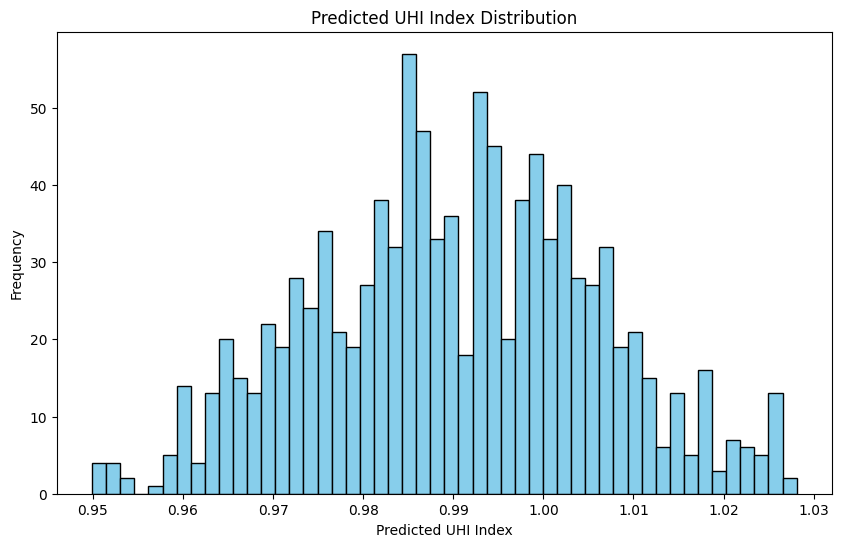

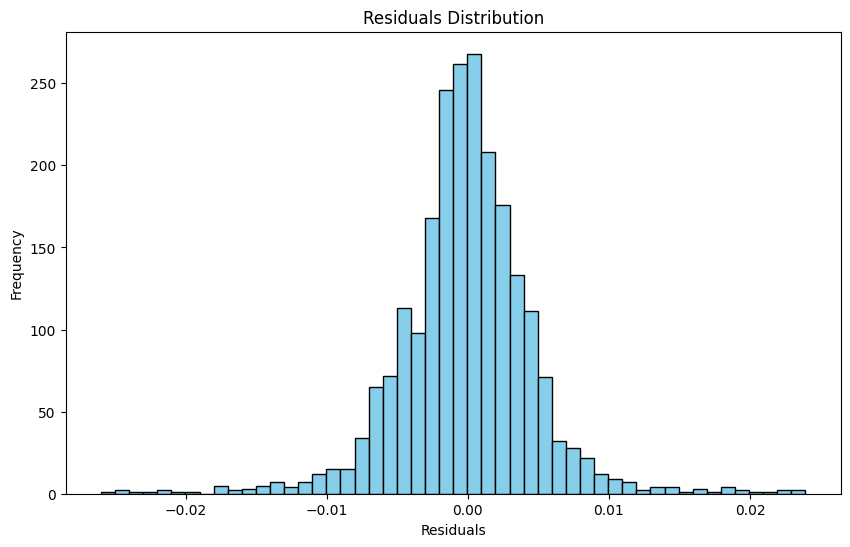

In [167]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.hist(submission_predictions_4, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Predicted UHI Index')
plt.ylabel('Frequency')
plt.title('Predicted UHI Index Distribution')
plt.show()

# Plot Residuals
plt.figure(figsize=(10, 6))
plt.hist(y_test - y_pred, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

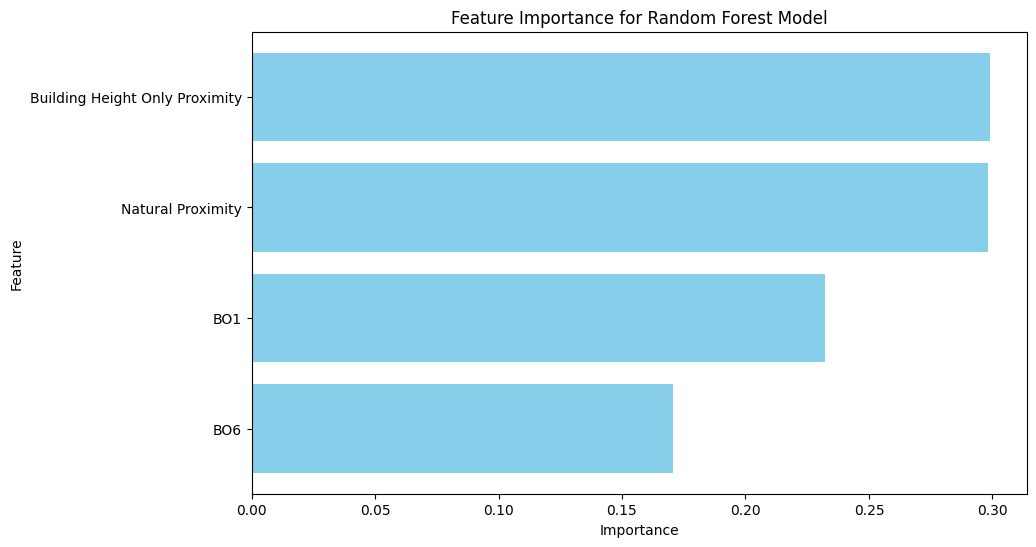

In [168]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [169]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

This got a 0.5 accuracy. Assess why:

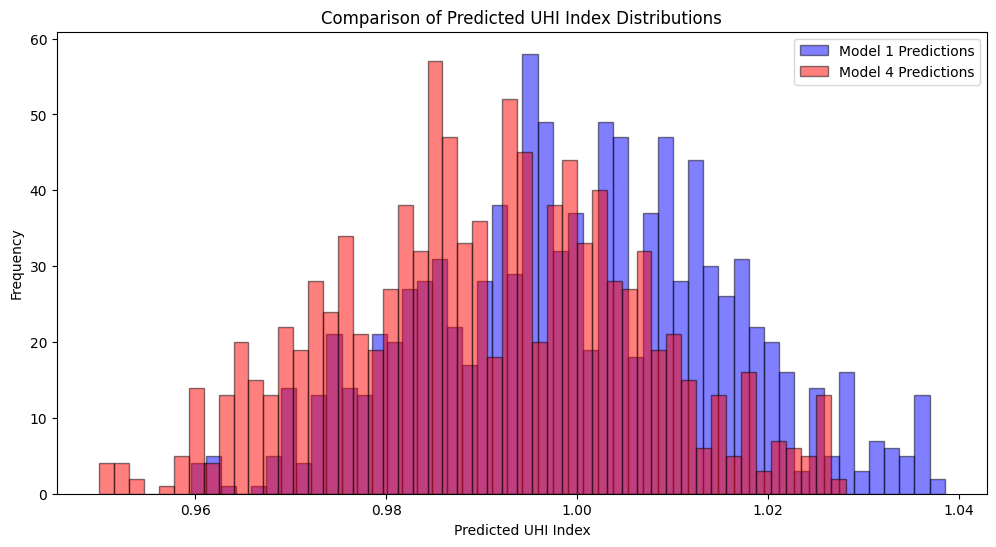

In [170]:
# Plot histograms for comparison
plt.figure(figsize=(12, 6))

# Histogram for submission_predictions_1
plt.hist(submission_predictions_1, bins=50, alpha=0.5, label='Model 1 Predictions', color='blue', edgecolor='black')

# Histogram for submission_predictions_3
plt.hist(submission_predictions_4, bins=50, alpha=0.5, label='Model 4 Predictions', color='red', edgecolor='black')

# Add labels and title
plt.xlabel('Predicted UHI Index')
plt.ylabel('Frequency')
plt.title('Comparison of Predicted UHI Index Distributions')
plt.legend()

# Show plot
plt.show()

The scaling shifted the entire graph to the left, but we want to interpret lower UHI values. We may need another satellite or other metrics to improve the model.

# New Satellite Data:

### New Sentinel Data on May 17, 2021:

This had similar temperature to the training data, which is why it was chosen. Here is our first run through:

In [241]:
sentinel_all_bands = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Sentinel_2_All_Bands_May_17_2021.csv")
landsat_all_bands_elevation = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\landsat_all_bands_elevation.csv")

In [242]:
# Add the landsat_thermal_granular data to the all_bands_proximity_rounded_3_mapped data
sentinel_updated_landsat_elevation = sentinel_all_bands.merge(landsat_all_bands_elevation[['Longitude', 'Latitude', 'Thermal', 'Red',
       'Green', 'Blue', 'Near Infared', 'Building Height Only Proximity',
       'Natural Proximity']], on=['Longitude', 'Latitude'])
sentinel_updated_landsat_elevation

# Save to CSV
sentinel_updated_landsat_elevation.to_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\sentinel_updated_landsat_elevation.csv", index=False)

# Load dataset
sentinel_updated_landsat_elevation = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\sentinel_updated_landsat_elevation.csv")

In [244]:
# Load dataset
df = sentinel_updated_landsat_elevation.copy()

# Define spectral features
spectral_features = ['Thermal','Red','Green','Blue','Near Infared', 'Building Height Only Proximity','Natural Proximity','B01',
       'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

# Select features and target
X = df[spectral_features]
y = df['UHI Index']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Not necessary for Random Forest but kept for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [245]:
# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluate model performance
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")

Model Performance:
 - MAE: 0.0036
 - RMSE: 0.0053


In [246]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist,
    n_iter=10, cv=3, scoring='neg_mean_absolute_error',
    verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

# Get the best model from hyperparameter tuning
best_rf_model = random_search.best_estimator_

# Enable Out-of-Bag (OOB) Score for validation
best_rf_model.set_params(oob_score=True)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate model on the test set
y_pred = best_rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation results
print(f"Optimized Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")
print(f"OOB Score: {best_rf_model.oob_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimized Model Performance:
 - MAE: 0.0035
 - RMSE: 0.0052
OOB Score: 0.8973379964301194


In [247]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds nearest spectral data to submission dataset using KDTree.

    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing submission locations (Latitude, Longitude).
        data_to_map (pd.DataFrame): DataFrame containing spectral band values.

    Returns:
        pd.DataFrame: Submission dataset with matched spectral data.
    """
    # Extract coordinates
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree
    tree = cKDTree(elevation_coords)
    
    # Find nearest neighbors
    _, indices = tree.query(uhi_coords)
    
    # Add matched spectral data
    uhi_data = uhi_data.copy()
    for col in spectral_features:
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

# Match spectral features for submission data
submission_all_bands_elevation = add_nearest_data(test_data, sentinel_updated_landsat_elevation)

In [248]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions_sentinel_updated_1 = rf_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions_sentinel_updated_1

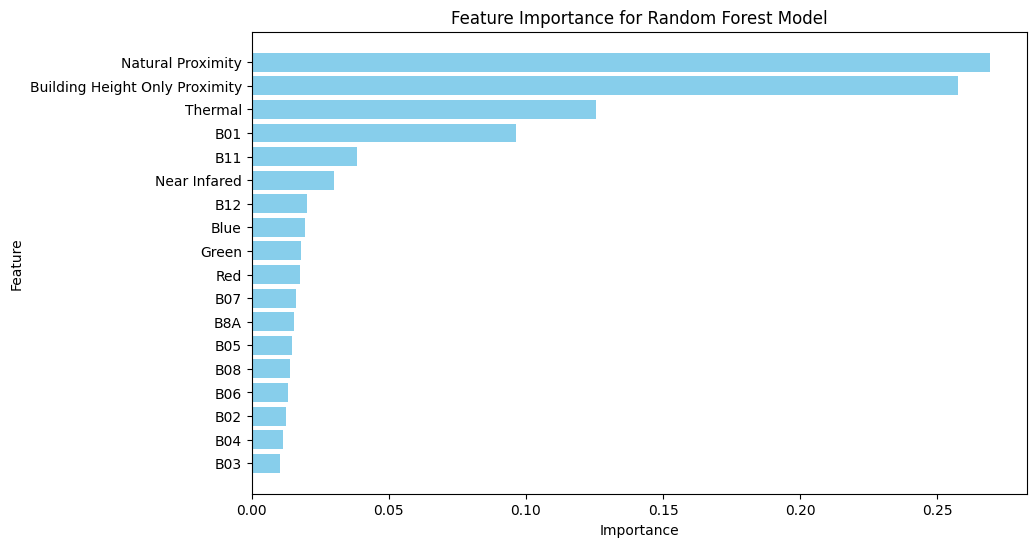

In [249]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [250]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

Model 2:

In [251]:
# Load dataset
df = sentinel_updated_landsat_elevation.copy()

# Define spectral features
spectral_features = ['Thermal','Building Height Only Proximity','Natural Proximity','B01']

# Select features and target
X = df[spectral_features]
y = df['UHI Index']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Not necessary for Random Forest but kept for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [252]:
# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluate model performance
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")

Model Performance:
 - MAE: 0.0029
 - RMSE: 0.0045


In [253]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist,
    n_iter=10, cv=3, scoring='neg_mean_absolute_error',
    verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

# Get the best model from hyperparameter tuning
best_rf_model = random_search.best_estimator_

# Enable Out-of-Bag (OOB) Score for validation
best_rf_model.set_params(oob_score=True)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate model on the test set
y_pred = best_rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation results
print(f"Optimized Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")
print(f"OOB Score: {best_rf_model.oob_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimized Model Performance:
 - MAE: 0.0029
 - RMSE: 0.0045
OOB Score: 0.930448166920715


In [254]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds nearest spectral data to submission dataset using KDTree.

    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing submission locations (Latitude, Longitude).
        data_to_map (pd.DataFrame): DataFrame containing spectral band values.

    Returns:
        pd.DataFrame: Submission dataset with matched spectral data.
    """
    # Extract coordinates
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree
    tree = cKDTree(elevation_coords)
    
    # Find nearest neighbors
    _, indices = tree.query(uhi_coords)
    
    # Add matched spectral data
    uhi_data = uhi_data.copy()
    for col in spectral_features:
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

# Match spectral features for submission data
submission_all_bands_elevation = add_nearest_data(test_data, sentinel_updated_landsat_elevation)

In [255]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions_sentinel_updated_2 = rf_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions_sentinel_updated_2

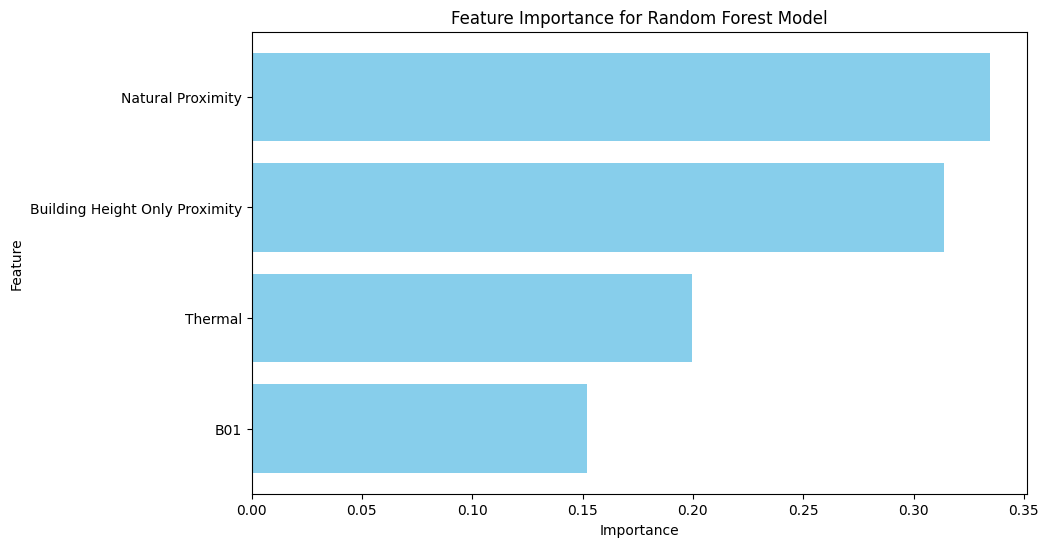

In [256]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [257]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

This got a 0.939. Might need to change the sentinel data slightly.

### Landsat on May 15, 2021:

This had similar temperature to the training data, which is why it was chosen. Here is our first run through:

In [171]:
landsat_all_bands = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Landsat_All_Bands_May_15_2021.csv")

In [ ]:
# Add the landsat_thermal_granular data to the all_bands_proximity_rounded_3_mapped data
landsat_all_bands_elevation = landsat_all_bands.merge(all_elevation_nyc[['Longitude', 'Latitude', 'Building Height Only Proximity','Natural Proximity']], on=['Longitude', 'Latitude'])
landsat_all_bands_elevation

# Save to CSV
landsat_all_bands_elevation.to_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\landsat_all_bands_elevation.csv", index=False)

# Load dataset
landsat_all_bands_elevation = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\landsat_all_bands_elevation.csv")

In [174]:
# Load dataset
df = landsat_all_bands_elevation.copy()

# Define spectral features
spectral_features = ['Thermal','Red','Green','Blue','Near Infared', 'Building Height Only Proximity','Natural Proximity']

# Select features and target
X = df[spectral_features]
y = df['UHI Index']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Not necessary for Random Forest but kept for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [175]:
# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluate model performance
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")

Model Performance:
 - MAE: 0.0032
 - RMSE: 0.0047


In [176]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist,
    n_iter=10, cv=3, scoring='neg_mean_absolute_error',
    verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

# Get the best model from hyperparameter tuning
best_rf_model = random_search.best_estimator_

# Enable Out-of-Bag (OOB) Score for validation
best_rf_model.set_params(oob_score=True)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate model on the test set
y_pred = best_rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation results
print(f"Optimized Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")
print(f"OOB Score: {best_rf_model.oob_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimized Model Performance:
 - MAE: 0.0032
 - RMSE: 0.0047
OOB Score: 0.9136469937287116


In [177]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds nearest spectral data to submission dataset using KDTree.

    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing submission locations (Latitude, Longitude).
        data_to_map (pd.DataFrame): DataFrame containing spectral band values.

    Returns:
        pd.DataFrame: Submission dataset with matched spectral data.
    """
    # Extract coordinates
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree
    tree = cKDTree(elevation_coords)
    
    # Find nearest neighbors
    _, indices = tree.query(uhi_coords)
    
    # Add matched spectral data
    uhi_data = uhi_data.copy()
    for col in spectral_features:
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

# Match spectral features for submission data
submission_all_bands_elevation = add_nearest_data(test_data, landsat_all_bands_elevation)

In [178]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions_landsat_1 = rf_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions_landsat_1

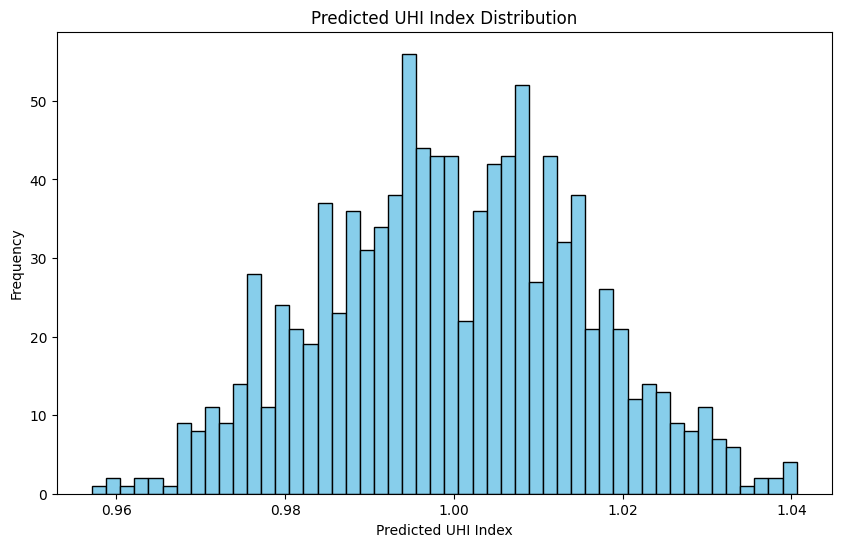

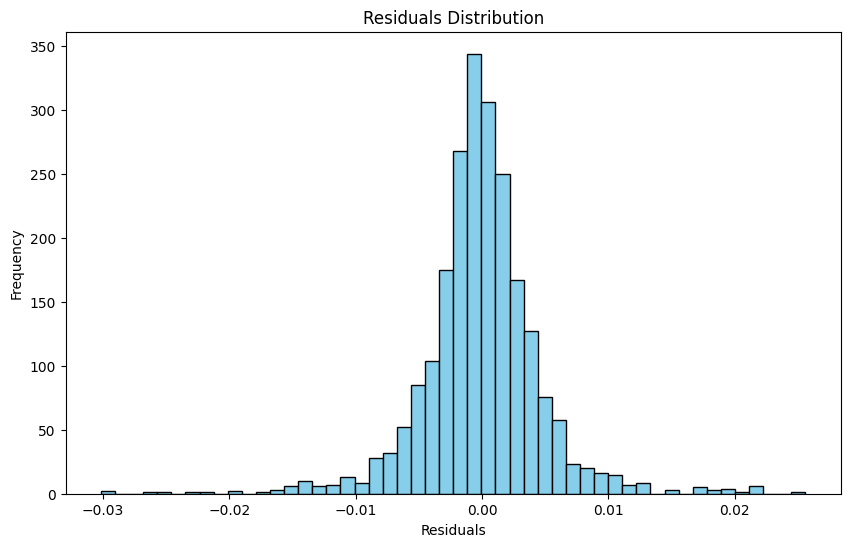

In [179]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.hist(submission_predictions_landsat_1, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Predicted UHI Index')
plt.ylabel('Frequency')
plt.title('Predicted UHI Index Distribution')
plt.show()

# Plot Residuals
plt.figure(figsize=(10, 6))
plt.hist(y_test - y_pred, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()


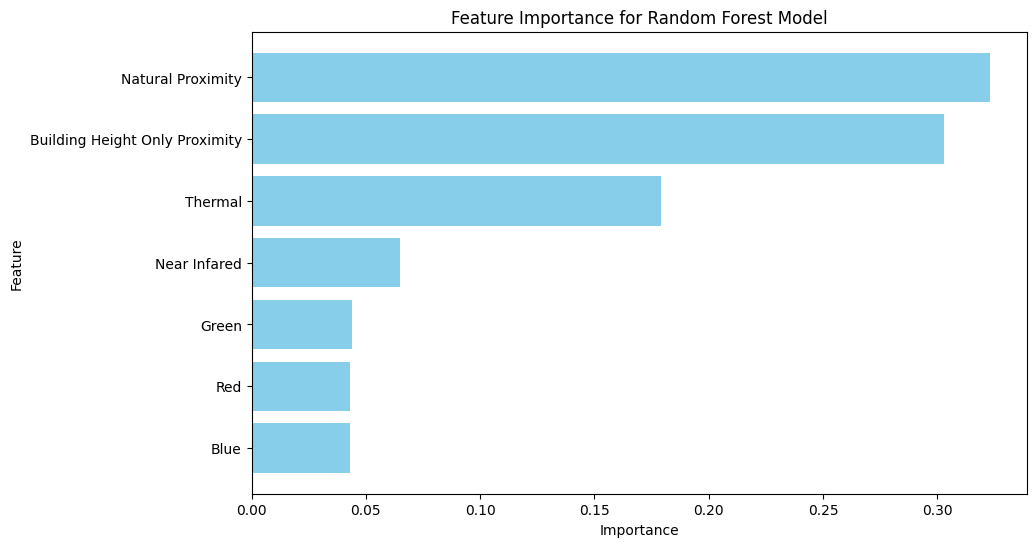

In [180]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

This got a 0.9401 accuracy. This is now the best model yet. 

### Model 2 Landsat:

In [183]:
# Load dataset
df = landsat_all_bands_elevation.copy()

# Define spectral features
spectral_features = ['Thermal','Near Infared', 'Building Height Only Proximity','Natural Proximity']

# Select features and target
X = df[spectral_features]
y = df['UHI Index']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Not necessary for Random Forest but kept for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [184]:
# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluate model performance
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")

Model Performance:
 - MAE: 0.0030
 - RMSE: 0.0045


In [185]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist,
    n_iter=10, cv=3, scoring='neg_mean_absolute_error',
    verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

# Get the best model from hyperparameter tuning
best_rf_model = random_search.best_estimator_

# Enable Out-of-Bag (OOB) Score for validation
best_rf_model.set_params(oob_score=True)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate model on the test set
y_pred = best_rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation results
print(f"Optimized Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")
print(f"OOB Score: {best_rf_model.oob_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimized Model Performance:
 - MAE: 0.0030
 - RMSE: 0.0045
OOB Score: 0.9236098768401615


In [186]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds nearest spectral data to submission dataset using KDTree.

    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing submission locations (Latitude, Longitude).
        data_to_map (pd.DataFrame): DataFrame containing spectral band values.

    Returns:
        pd.DataFrame: Submission dataset with matched spectral data.
    """
    # Extract coordinates
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree
    tree = cKDTree(elevation_coords)
    
    # Find nearest neighbors
    _, indices = tree.query(uhi_coords)
    
    # Add matched spectral data
    uhi_data = uhi_data.copy()
    for col in spectral_features:
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

# Match spectral features for submission data
submission_all_bands_elevation = add_nearest_data(test_data, landsat_all_bands_elevation)

In [187]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions_landsat_2 = rf_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions_landsat_2

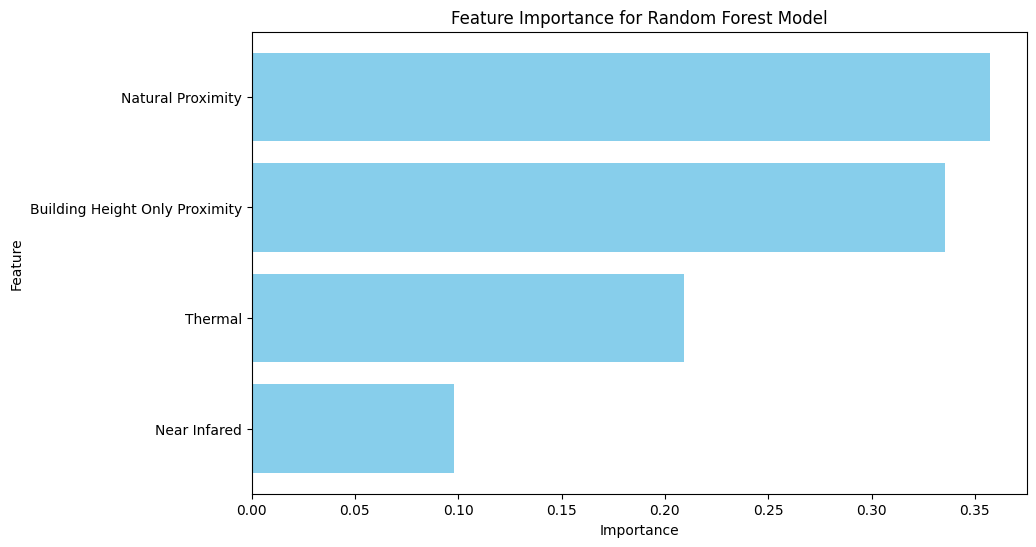

In [188]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [189]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

This gota 0.9425 accuracy. So, now our best model again. Let's remove the near infared.

### Model 3 Landsat:

In [190]:
# Load dataset
df = landsat_all_bands_elevation.copy()

# Define spectral features
spectral_features = ['Thermal','Building Height Only Proximity','Natural Proximity']

# Select features and target
X = df[spectral_features]
y = df['UHI Index']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Not necessary for Random Forest but kept for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [191]:
# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluate model performance
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")

Model Performance:
 - MAE: 0.0029
 - RMSE: 0.0044


In [192]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist,
    n_iter=10, cv=3, scoring='neg_mean_absolute_error',
    verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

# Get the best model from hyperparameter tuning
best_rf_model = random_search.best_estimator_

# Enable Out-of-Bag (OOB) Score for validation
best_rf_model.set_params(oob_score=True)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate model on the test set
y_pred = best_rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation results
print(f"Optimized Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")
print(f"OOB Score: {best_rf_model.oob_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimized Model Performance:
 - MAE: 0.0029
 - RMSE: 0.0044
OOB Score: 0.9308371497442005


In [193]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions_landsat_2 = rf_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions_landsat_2

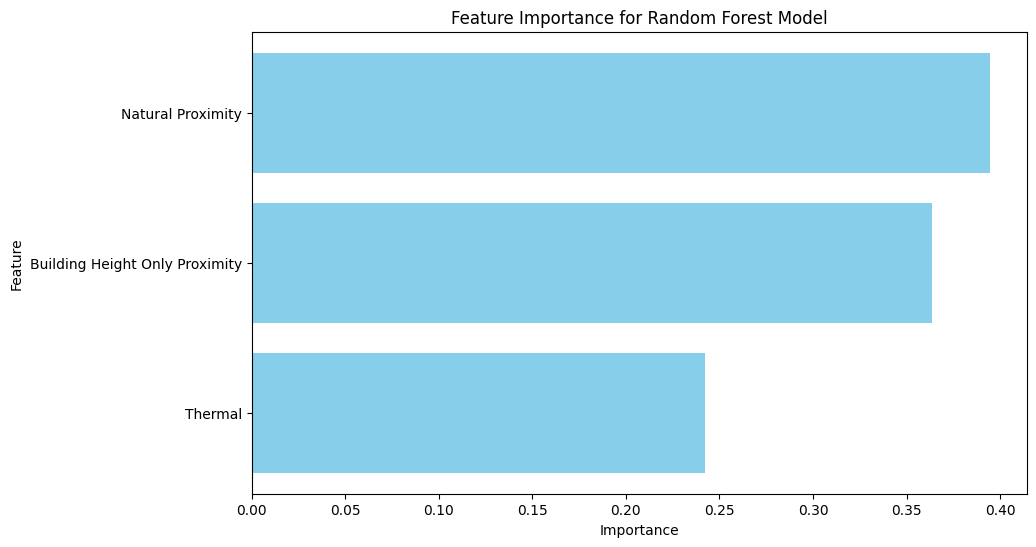

In [194]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [195]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

### Landsat and Sentinel Data Model 1:

In [320]:
# Add the landsat_thermal_granular data to the all_bands_proximity_rounded_3_mapped data
landsat_sentinel_elevation = landsat_all_bands_elevation.merge(noisy_5_bands_proxmity[['Longitude', 'Latitude', 'BO1',
       'BO2', 'BO3', 'BO4', 'BO5', 'BO6', 'BO7', 'BO8', 'B8A', 'B11', 'B12']], on=['Longitude', 'Latitude'])
landsat_sentinel_elevation

# Save to CSV
landsat_sentinel_elevation.to_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\landsat_sentinel_elevation.csv", index=False)

# Load dataset
landsat_sentinel_elevation = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\landsat_sentinel_elevation.csv")

In [203]:
# Load dataset
df = landsat_sentinel_elevation.copy()

# Define spectral features
spectral_features = ['Thermal','Red','Green','Blue','Near Infared', 'Building Height Only Proximity','Natural Proximity','BO1',
       'BO2', 'BO3', 'BO4', 'BO5', 'BO6', 'BO7', 'BO8', 'B8A', 'B11', 'B12']

# Select features and target
X = df[spectral_features]
y = df['UHI Index']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Not necessary for Random Forest but kept for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [204]:
# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluate model performance
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")

Model Performance:
 - MAE: 0.0026
 - RMSE: 0.0039


In [205]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist,
    n_iter=10, cv=3, scoring='neg_mean_absolute_error',
    verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

# Get the best model from hyperparameter tuning
best_rf_model = random_search.best_estimator_

# Enable Out-of-Bag (OOB) Score for validation
best_rf_model.set_params(oob_score=True)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate model on the test set
y_pred = best_rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation results
print(f"Optimized Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")
print(f"OOB Score: {best_rf_model.oob_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimized Model Performance:
 - MAE: 0.0026
 - RMSE: 0.0039
OOB Score: 0.9453676355066496


In [206]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds nearest spectral data to submission dataset using KDTree.

    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing submission locations (Latitude, Longitude).
        data_to_map (pd.DataFrame): DataFrame containing spectral band values.

    Returns:
        pd.DataFrame: Submission dataset with matched spectral data.
    """
    # Extract coordinates
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree
    tree = cKDTree(elevation_coords)
    
    # Find nearest neighbors
    _, indices = tree.query(uhi_coords)
    
    # Add matched spectral data
    uhi_data = uhi_data.copy()
    for col in spectral_features:
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

# Match spectral features for submission data
submission_all_bands_elevation = add_nearest_data(test_data, landsat_sentinel_elevation)

In [207]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions_landsat_sentinel_1 = rf_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions_landsat_sentinel_1

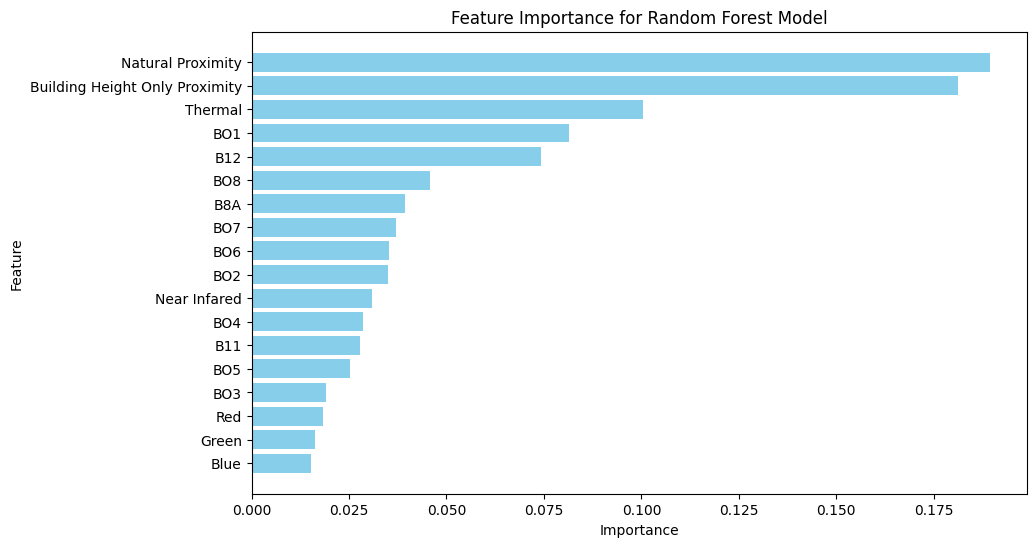

In [208]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [209]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

This got an accuracy of 0.9526. Once again, found another greater model.

### Landsat and Sentinel Model 2:

In [214]:
# Load dataset
df = landsat_sentinel_elevation.copy()

# Define spectral features
spectral_features = ['Thermal','Building Height Only Proximity','Natural Proximity','BO1','B12']

# Select features and target
X = df[spectral_features]
y = df['UHI Index']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Not necessary for Random Forest but kept for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [215]:
# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluate model performance
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")

Model Performance:
 - MAE: 0.0027
 - RMSE: 0.0040


In [216]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist,
    n_iter=10, cv=3, scoring='neg_mean_absolute_error',
    verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

# Get the best model from hyperparameter tuning
best_rf_model = random_search.best_estimator_

# Enable Out-of-Bag (OOB) Score for validation
best_rf_model.set_params(oob_score=True)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate model on the test set
y_pred = best_rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation results
print(f"Optimized Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")
print(f"OOB Score: {best_rf_model.oob_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimized Model Performance:
 - MAE: 0.0027
 - RMSE: 0.0039
OOB Score: 0.9435632599196828


In [217]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds nearest spectral data to submission dataset using KDTree.

    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing submission locations (Latitude, Longitude).
        data_to_map (pd.DataFrame): DataFrame containing spectral band values.

    Returns:
        pd.DataFrame: Submission dataset with matched spectral data.
    """
    # Extract coordinates
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree
    tree = cKDTree(elevation_coords)
    
    # Find nearest neighbors
    _, indices = tree.query(uhi_coords)
    
    # Add matched spectral data
    uhi_data = uhi_data.copy()
    for col in spectral_features:
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

# Match spectral features for submission data
submission_all_bands_elevation = add_nearest_data(test_data, landsat_sentinel_elevation)

In [218]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions_landsat_sentinel_2 = rf_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions_landsat_sentinel_2

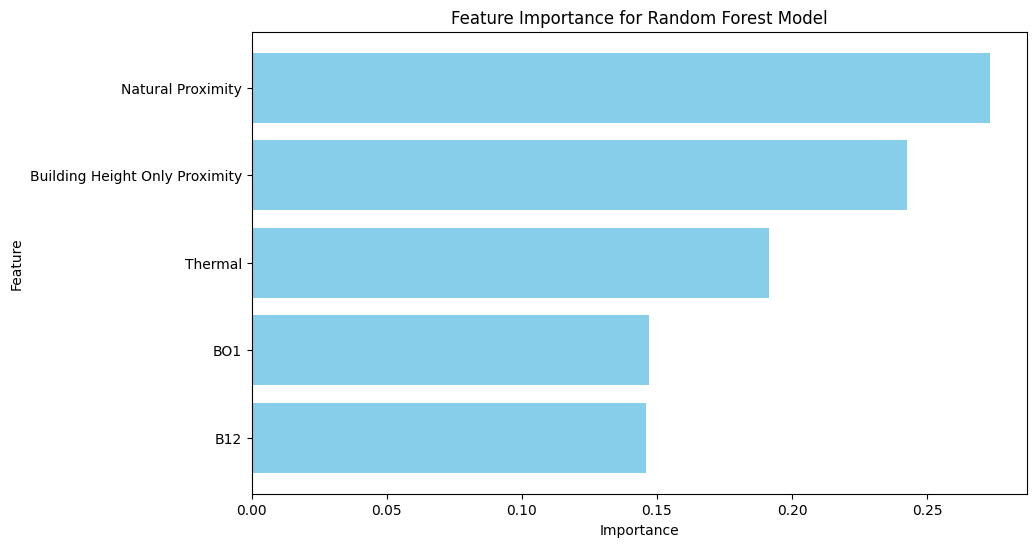

In [219]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [220]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

This got an accuracy of 0.9524. We can maybe add some of the features back and remove the least important to get a better model.

### Landsat and Sentinel Model 3:

In [222]:
# Load dataset
df = landsat_sentinel_elevation.copy()

# Define spectral features
spectral_features = ['Thermal','Near Infared', 'Building Height Only Proximity','Natural Proximity','BO1',
       'BO2', 'BO4', 'BO5', 'BO6', 'BO7', 'BO8', 'B8A', 'B11', 'B12']

# Select features and target
X = df[spectral_features]
y = df['UHI Index']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Not necessary for Random Forest but kept for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [223]:
# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluate model performance
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")

Model Performance:
 - MAE: 0.0026
 - RMSE: 0.0039


In [224]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist,
    n_iter=10, cv=3, scoring='neg_mean_absolute_error',
    verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

# Get the best model from hyperparameter tuning
best_rf_model = random_search.best_estimator_

# Enable Out-of-Bag (OOB) Score for validation
best_rf_model.set_params(oob_score=True)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate model on the test set
y_pred = best_rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation results
print(f"Optimized Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")
print(f"OOB Score: {best_rf_model.oob_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimized Model Performance:
 - MAE: 0.0026
 - RMSE: 0.0039
OOB Score: 0.9461214215988905


In [225]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds nearest spectral data to submission dataset using KDTree.

    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing submission locations (Latitude, Longitude).
        data_to_map (pd.DataFrame): DataFrame containing spectral band values.

    Returns:
        pd.DataFrame: Submission dataset with matched spectral data.
    """
    # Extract coordinates
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree
    tree = cKDTree(elevation_coords)
    
    # Find nearest neighbors
    _, indices = tree.query(uhi_coords)
    
    # Add matched spectral data
    uhi_data = uhi_data.copy()
    for col in spectral_features:
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

# Match spectral features for submission data
submission_all_bands_elevation = add_nearest_data(test_data, landsat_sentinel_elevation)

In [226]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions_landsat_sentinel_3 = rf_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions_landsat_sentinel_3

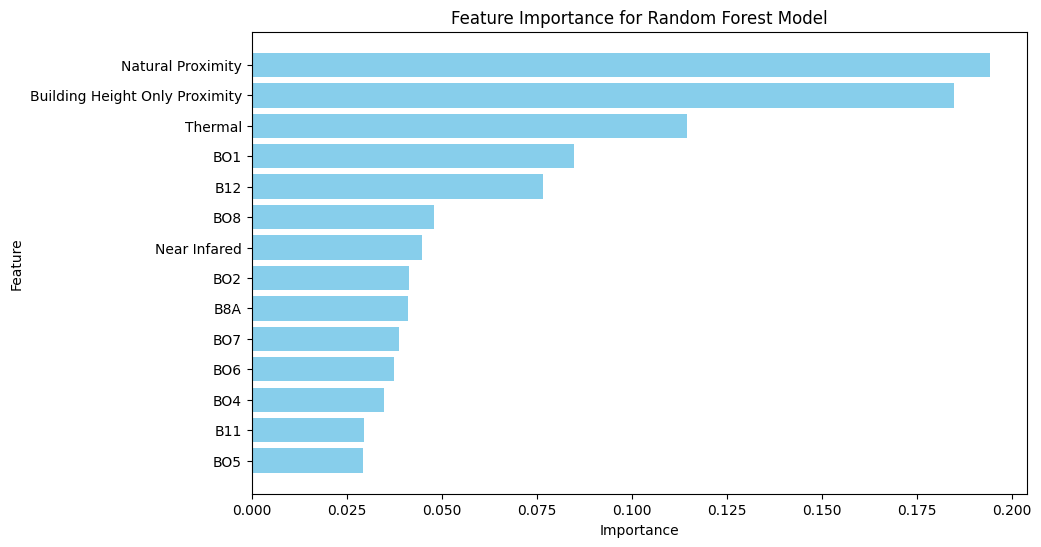

In [227]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [228]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

This got a 0.954 accuracy.

### Landsat and Sentinel Model 4:

In [229]:
# Load dataset
df = landsat_sentinel_elevation.copy()

# Define spectral features
spectral_features = ['Thermal','Near Infared', 'Building Height Only Proximity','Natural Proximity','BO1',
       'BO2', 'BO6', 'BO7', 'BO8', 'B8A', 'B12']

# Select features and target
X = df[spectral_features]
y = df['UHI Index']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Not necessary for Random Forest but kept for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [230]:
# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluate model performance
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")

Model Performance:
 - MAE: 0.0026
 - RMSE: 0.0039


In [231]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist,
    n_iter=10, cv=3, scoring='neg_mean_absolute_error',
    verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

# Get the best model from hyperparameter tuning
best_rf_model = random_search.best_estimator_

# Enable Out-of-Bag (OOB) Score for validation
best_rf_model.set_params(oob_score=True)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate model on the test set
y_pred = best_rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation results
print(f"Optimized Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")
print(f"OOB Score: {best_rf_model.oob_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimized Model Performance:
 - MAE: 0.0026
 - RMSE: 0.0039
OOB Score: 0.9461147884398095


In [ ]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds nearest spectral data to submission dataset using KDTree.

    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing submission locations (Latitude, Longitude).
        data_to_map (pd.DataFrame): DataFrame containing spectral band values.

    Returns:
        pd.DataFrame: Submission dataset with matched spectral data.
    """
    # Extract coordinates
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree
    tree = cKDTree(elevation_coords)
    
    # Find nearest neighbors
    _, indices = tree.query(uhi_coords)
    
    # Add matched spectral data
    uhi_data = uhi_data.copy()
    for col in spectral_features:
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

# Match spectral features for submission data
submission_all_bands_elevation = add_nearest_data(test_data, landsat_sentinel_elevation)

In [232]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions_landsat_sentinel_4 = rf_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions_landsat_sentinel_4

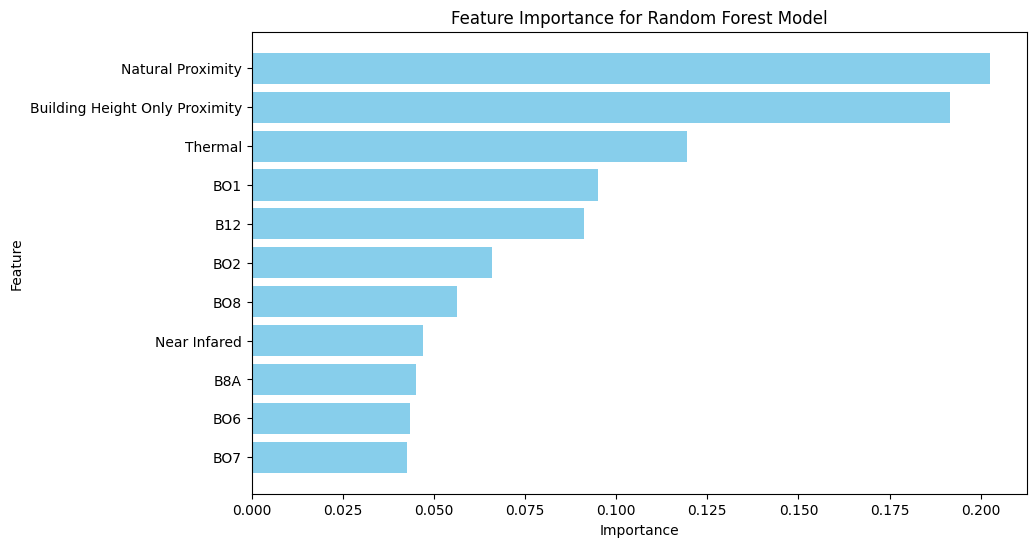

In [233]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [234]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

This got a 0.9537. Therefore, we have now reduced too many features. We are going to lose some accuracy. Our next step may be to update the sentinel data appropriately or get more satellite data.

# New Sentinel Data with the Other Data:

### Model 1:

In [322]:
sentinel_1_bands = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Sentinel_1_All_Bands_July_26_2021.csv")

In [261]:
sentinel_1_bands

,Longitude,Latitude,datetime,UHI Index,vv,vh
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,396.0,199.0
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,396.0,199.0
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,661.0,177.0
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,661.0,177.0
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,421.0,185.0
...,...,...,...,...,...,...
11224,-73.957050,40.790333,24-07-2021 15:57,0.972470,136.0,105.0
11225,-73.957063,40.790308,24-07-2021 15:57,0.972470,136.0,105.0
11226,-73.957093,40.790270,24-07-2021 15:57,0.981124,136.0,105.0
11227,-73.957112,40.790253,24-07-2021 15:59,0.981245,136.0,105.0


In [323]:
# Add the landsat_thermal_granular data to the all_bands_proximity_rounded_3_mapped data
landsat_sentinel_1_and_2_elevation = landsat_sentinel_elevation.merge(sentinel_1_bands[['Longitude', 'Latitude','vv','vh']], on=['Longitude', 'Latitude'])
landsat_sentinel_1_and_2_elevation

# Save to CSV
landsat_sentinel_1_and_2_elevation.to_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\landsat_sentinel_1_and_2_elevation.csv", index=False)

# Load dataset
landsat_sentinel_1_and_2_elevation = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\landsat_sentinel_1_and_2_elevation.csv")

In [263]:
# Load dataset
df = landsat_sentinel_1_and_2_elevation.copy()

# Define spectral features
spectral_features = ['Thermal','Red','Green','Blue','Near Infared', 'Building Height Only Proximity','Natural Proximity','BO1',
       'BO2', 'BO3', 'BO4', 'BO5', 'BO6', 'BO7', 'BO8', 'B8A', 'B11', 'B12','vv','vh']

# Select features and target
X = df[spectral_features]
y = df['UHI Index']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Not necessary for Random Forest but kept for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [264]:
# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluate model performance
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")

Model Performance:
 - MAE: 0.0026
 - RMSE: 0.0039


In [265]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist,
    n_iter=10, cv=3, scoring='neg_mean_absolute_error',
    verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

# Get the best model from hyperparameter tuning
best_rf_model = random_search.best_estimator_

# Enable Out-of-Bag (OOB) Score for validation
best_rf_model.set_params(oob_score=True)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate model on the test set
y_pred = best_rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation results
print(f"Optimized Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")
print(f"OOB Score: {best_rf_model.oob_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimized Model Performance:
 - MAE: 0.0026
 - RMSE: 0.0038
OOB Score: 0.9461913304864235


In [266]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds nearest spectral data to submission dataset using KDTree.

    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing submission locations (Latitude, Longitude).
        data_to_map (pd.DataFrame): DataFrame containing spectral band values.

    Returns:
        pd.DataFrame: Submission dataset with matched spectral data.
    """
    # Extract coordinates
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree
    tree = cKDTree(elevation_coords)
    
    # Find nearest neighbors
    _, indices = tree.query(uhi_coords)
    
    # Add matched spectral data
    uhi_data = uhi_data.copy()
    for col in spectral_features:
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

# Match spectral features for submission data
submission_all_bands_elevation = add_nearest_data(test_data, landsat_sentinel_1_and_2_elevation)

In [267]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions_landsat_sentinel_1_and_2_1 = rf_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions_landsat_sentinel_1_and_2_1

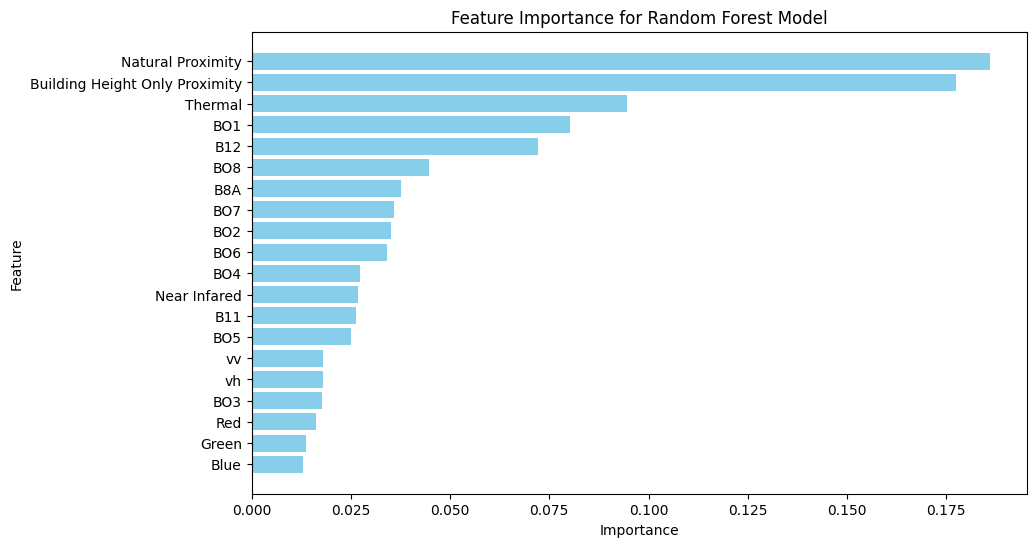

In [268]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [269]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

This model was 0.9586 accuracy.

### Model 2:

In [270]:
# Load dataset
df = landsat_sentinel_1_and_2_elevation.copy()

# Define spectral features
spectral_features = ['Thermal','Near Infared', 'Building Height Only Proximity','Natural Proximity','BO1',
       'BO2', 'BO3', 'BO4', 'BO5', 'BO6', 'BO7', 'BO8', 'B8A', 'B11', 'B12','vv','vh']

# Select features and target
X = df[spectral_features]
y = df['UHI Index']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Not necessary for Random Forest but kept for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [271]:
# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluate model performance
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")

Model Performance:
 - MAE: 0.0027
 - RMSE: 0.0039


In [272]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist,
    n_iter=10, cv=3, scoring='neg_mean_absolute_error',
    verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

# Get the best model from hyperparameter tuning
best_rf_model = random_search.best_estimator_

# Enable Out-of-Bag (OOB) Score for validation
best_rf_model.set_params(oob_score=True)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate model on the test set
y_pred = best_rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation results
print(f"Optimized Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")
print(f"OOB Score: {best_rf_model.oob_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimized Model Performance:
 - MAE: 0.0026
 - RMSE: 0.0039
OOB Score: 0.9458045876900767


In [273]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds nearest spectral data to submission dataset using KDTree.

    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing submission locations (Latitude, Longitude).
        data_to_map (pd.DataFrame): DataFrame containing spectral band values.

    Returns:
        pd.DataFrame: Submission dataset with matched spectral data.
    """
    # Extract coordinates
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree
    tree = cKDTree(elevation_coords)
    
    # Find nearest neighbors
    _, indices = tree.query(uhi_coords)
    
    # Add matched spectral data
    uhi_data = uhi_data.copy()
    for col in spectral_features:
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

# Match spectral features for submission data
submission_all_bands_elevation = add_nearest_data(test_data, landsat_sentinel_1_and_2_elevation)

In [274]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions_landsat_sentinel_1_and_2_1 = rf_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions_landsat_sentinel_1_and_2_1

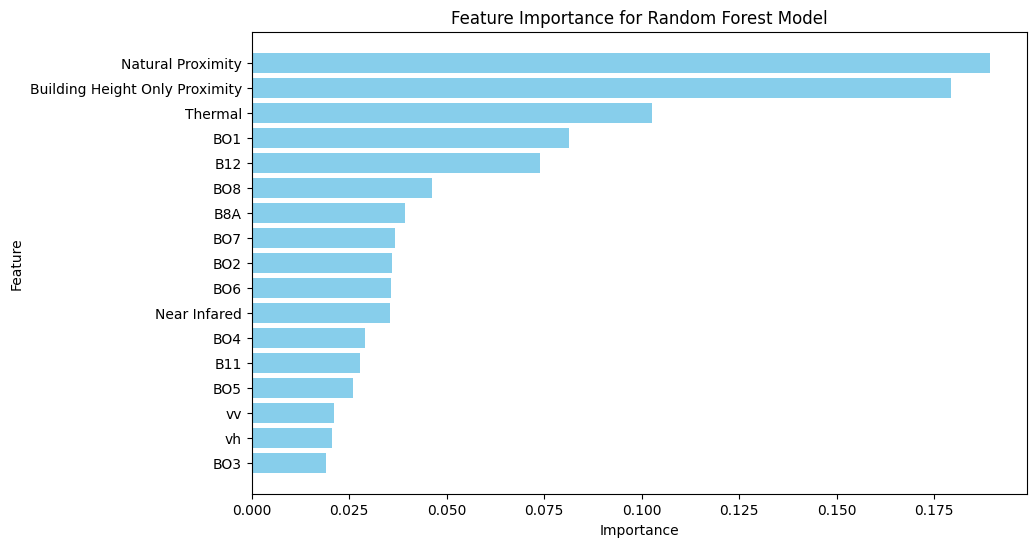

In [275]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [276]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

This model was 0.9589 accuracy.

# Proximity Rounding Data:

### Model 1:

I am going to look at the data rounded in different ways. 

In [7]:
# Load dataset
landsat_sentinel_1_and_2_elevation = pd.read_csv("C:\\Users\\jrzem\\OneDrive\\Desktop\\EY Dataset\\Satellite Data\\landsat_sentinel_1_and_2_elevation.csv")

In [8]:
# Load dataset
df = landsat_sentinel_1_and_2_elevation.copy()
# Define spectral features
spectral_features = ['Thermal', 'Red',
       'Green', 'Blue', 'Near Infared', 'Building Height Only Proximity',
       'Natural Proximity', 'BO1', 'BO2', 'BO3', 'BO4', 'BO5', 'BO6', 'BO7',
       'BO8', 'B8A', 'B11', 'B12', 'vv', 'vh']

# Select features and target
X = df[spectral_features]
y = df['UHI Index']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization (Not necessary for Random Forest but kept for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluate model performance
y_pred = rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")

Model Performance:
 - MAE: 0.0026
 - RMSE: 0.0039


In [328]:
# Define the parameter grid for hyperparameter tuning
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Perform Randomized Search for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf, param_distributions=param_dist,
    n_iter=10, cv=3, scoring='neg_mean_absolute_error',
    verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

# Get the best model from hyperparameter tuning
best_rf_model = random_search.best_estimator_

# Enable Out-of-Bag (OOB) Score for validation
best_rf_model.set_params(oob_score=True)
best_rf_model.fit(X_train_scaled, y_train)

# Evaluate model on the test set
y_pred = best_rf_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print evaluation results
print(f"Optimized Model Performance:\n - MAE: {mae:.4f}\n - RMSE: {rmse:.4f}")
print(f"OOB Score: {best_rf_model.oob_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Optimized Model Performance:
 - MAE: 0.0026
 - RMSE: 0.0038
OOB Score: 0.9461913304864235


Now use the rounded data for the test.

In [330]:
landsat_test_proximity = pd.read_csv("C:\\Users\\jrzem\\Downloads\\landsat_test_data.csv")
sentinel_test_proximity = pd.read_csv("C:\\Users\\jrzem\\Downloads\\sentinel_test_data.csv")
natural_elevation_proximity = pd.read_csv("C:\\Users\\jrzem\\Downloads\\natural_elevation_proximity.csv")
building_elevation_proximity = pd.read_csv("C:\\Users\\jrzem\\Downloads\\building_elevation_proximity.csv")
all_bands_proximity_rounded_3 = pd.read_csv("C:\\Users\\jrzem\\Downloads\\all_bands_proximity_rounded_3.csv")

In [357]:
all_bands_proximity_rounded_3

,Unnamed: 0,Longitude,Latitude,BO1,BO2,BO3,BO4,BO5,BO6,BO7,BO8,B8A,B11,B12
0,0,-73.995,40.771,1112.000000,1727.000000,1916.857143,2084.857143,1946.571429,1954.428571,2046.142857,2128.714286,2029.500000,2018.428571,1859.785714
1,1,-73.995,40.772,1112.000000,1589.500000,1789.000000,1911.250000,1680.000000,1720.000000,1744.000000,1940.250000,1741.500000,1841.000000,1732.500000
2,2,-73.994,40.771,1230.796875,1536.765625,1685.562500,1812.593750,1950.468750,1986.281250,2042.953125,1955.406250,2026.343750,2129.625000,2016.328125
3,3,-73.994,40.772,1269.559113,1400.694581,1561.847291,1656.394089,1767.554187,1774.463054,1809.963054,1734.645320,1771.002463,1891.241379,1800.800493
4,4,-73.994,40.773,1205.742857,1327.842857,1477.842857,1556.671429,1760.585714,1797.428571,1867.814286,1821.742857,1886.714286,1854.428571,1641.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,1562,-73.880,40.808,1673.827273,1467.063636,1594.227273,1701.218182,1886.359091,1898.913636,1939.277273,1805.372727,1943.213636,2264.218182,2139.686364
1563,1563,-73.880,40.809,1245.406977,1512.430233,1629.872093,1735.127907,1845.424419,1912.988372,1948.813953,1896.697674,1949.319767,2079.122093,1896.883721
1564,1564,-73.880,40.810,1140.285714,994.785714,1100.857143,1154.500000,1277.642857,1476.214286,1584.714286,1550.285714,1606.714286,1578.214286,1472.214286
1565,1565,-73.879,40.806,1002.138462,1075.207692,1170.930769,1224.276923,1308.630769,1500.323077,1573.130769,1398.923077,1591.846154,1657.700000,1438.953846


In [356]:
natural_elevation_proximity

,Unnamed: 0,Longitude,Latitude,Natural Elevation
0,0,-73.994,40.760,29.074947
1,1,-73.994,40.761,31.431286
2,2,-73.994,40.762,32.541364
3,3,-73.994,40.763,30.439941
4,4,-73.994,40.764,30.227364
...,...,...,...,...
6189,6189,-73.879,40.825,16.322667
6190,6190,-73.879,40.827,22.272667
6191,6191,-73.879,40.831,53.666000
6192,6192,-73.879,40.833,50.298000


In [353]:
# Mapping proximity rounded:
landsat_sentinel_1 = landsat_test_proximity.merge(sentinel_test_proximity[['Longitude', 'Latitude','vv','vh']], on=['Longitude', 'Latitude'])
landsat_sentinel_1['Thermal'] = landsat_sentinel_1['lwir11']
landsat_sentinel_1['Near Infared'] = landsat_sentinel_1['nir08']
landsat_sentinel_1['Red'] = landsat_sentinel_1['red']
landsat_sentinel_1['Green'] = landsat_sentinel_1['green']
landsat_sentinel_1['Blue'] = landsat_sentinel_1['blue']
landsat_sentinel_1.drop(columns=['lwir11','nir08','red','green','blue'], inplace=True)

In [354]:
landsat_sentinel_1

,Unnamed: 0,Longitude,Latitude,UHI Index,vv,vh,Thermal,Near Infared,Red,Green,Blue
0,0,-73.971665,40.788763,NaN,511.50,270.50,45702.0,16092.0,10133.0,10250.0,9515.0
1,1,-73.971928,40.788875,NaN,511.50,270.50,45702.0,16092.0,10133.0,10250.0,9515.0
2,2,-73.967080,40.789080,NaN,586.50,313.00,45198.0,13439.0,10818.0,10673.0,10039.0
3,3,-73.972550,40.789082,NaN,379.25,228.25,45775.0,15334.0,13198.5,12547.0,11943.0
4,4,-73.969697,40.787953,NaN,365.50,248.50,45386.0,17009.0,11664.0,11395.0,10873.0
...,...,...,...,...,...,...,...,...,...,...,...
1035,1035,-73.919388,40.813803,NaN,375.50,199.50,46765.0,14020.0,13044.0,12585.0,11693.0
1036,1036,-73.931033,40.833178,NaN,362.00,132.50,45476.0,16856.0,11446.0,11342.0,10521.0
1037,1037,-73.934647,40.854542,NaN,282.75,175.00,46378.0,15121.0,11447.0,11379.0,10888.0
1038,1038,-73.917223,40.815413,NaN,265.50,107.50,46930.0,17957.0,15294.0,14652.0,13997.0


In [355]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds nearest spectral data to submission dataset using KDTree.

    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing submission locations (Latitude, Longitude).
        data_to_map (pd.DataFrame): DataFrame containing spectral band values.

    Returns:
        pd.DataFrame: Submission dataset with matched spectral data.
    """
    # Extract coordinates
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree
    tree = cKDTree(elevation_coords)
    
    # Find nearest neighbors
    _, indices = tree.query(uhi_coords)
    
    # Add matched spectral data
    uhi_data = uhi_data.copy()
    for col in spectral_features:
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

# Match spectral features for submission data
landsat_sentinel = add_nearest_data(test_data, landsat_sentinel_1)

KeyError: 'Building Height Only Proximity'

In [ ]:
submission_all_bands_elevation = add_nearest_data()

In [302]:
# Prepare submission data for prediction
x_submission_test = submission_all_bands_elevation[spectral_features]

# Standardize submission data using the same scaler
x_submission_test_scaled = scaler.transform(x_submission_test)

# Make predictions
submission_predictions_landsat_sentinel_1_and_2_proximity_1 = rf_model.predict(x_submission_test_scaled)

# Add predictions to submission DataFrame
submission_all_bands_elevation["UHI Index"] = submission_predictions_landsat_sentinel_1_and_2_proximity_1

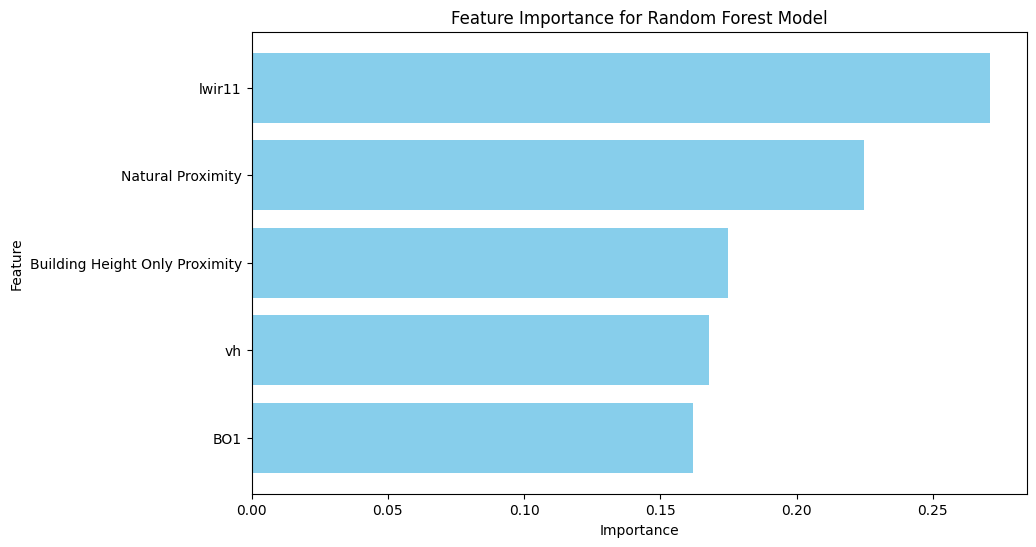

In [303]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': spectral_features,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [304]:
# Load the final submission
submission_all_bands_elevation_final = submission_all_bands_elevation[['Longitude', 'Latitude', 'UHI Index']]
submission_all_bands_elevation_final.to_csv("C:\\Users\\jrzem\\Downloads\\submission_all_bands_elevation.csv", index=False)

This got about 0.93 for accuracy, so the proximity method isn't as effective as we hoped here. 

# Conclusion: